In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [186]:
# 1 point
def scale(X):
    return (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [187]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [188]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.copy_ = copy
        self.with_mean_ = with_mean
        self.with_std_ = with_std

    def fit(self, X, y=None):
        X = np.array(X)
        self.mean_ = np.zeros(X.shape[1])
        if (self.with_mean_ == True):
            self.mean_ = np.mean(X, axis=0)
        
        self.std_ = np.ones(X.shape[1])
        if (self.with_std_ == True):
            self.std_ = np.std(X, axis=0)

        return self

    def transform(self, X, y=None, copy=None):
        return (np.array(X) - self.mean_)/self.std_
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, fit_params)
        return self.transform(X)

In [189]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [190]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ -0.97436156,  -0.94491753],
       [  2.91757481,  -0.03368518],
       [ 10.6195511 ,  -0.94601505],
       ...,
       [  6.48486152,   5.84143378],
       [-21.38350852,   4.63619204],
       [  5.53823954,   6.20637418]])

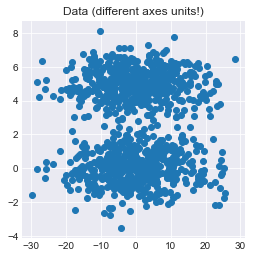

In [191]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

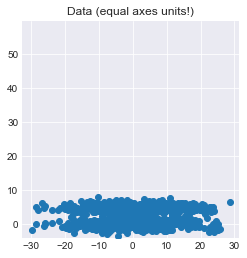

In [192]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

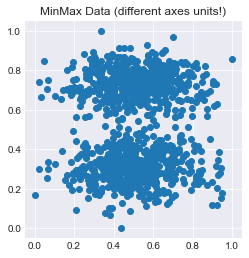

In [193]:
min_max_scaler = MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(data)
plot_scatter(data_minmax[:,0], data_minmax[:,1], auto_scaled=False, title='MinMax Data (different axes units!)')

### StandardScaler (0.5 point)

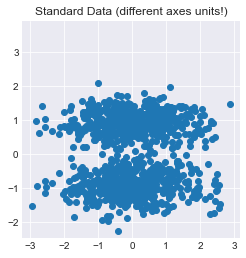

In [194]:
standard_scaler = StandardScaler()
data_standard = standard_scaler.fit_transform(data)
plot_scatter(data_standard[:,0], data_standard[:,1], auto_scaled=False, title='Standard Data (different axes units!)')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [195]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 2)

#1) get clusters from the original unscaled data.
labels = kmeans.fit_predict(data)
filtered_labels_0 = data[labels == 0]
filtered_labels_1 = data[labels == 1]

#2) get clusters from the scaled data (MinMax).
labels_minmax = kmeans.fit_predict(data_minmax)
filtered_labels_minmax_0 = data_minmax[labels_minmax == 0]
filtered_labels_minmax_1 = data_minmax[labels_minmax == 1]

#3) get clusters from the scaled data (Standard).
labels_standard = kmeans.fit_predict(data_standard)
filtered_labels_standard_0 = data_standard[labels_standard == 0]
filtered_labels_standard_1 = data_standard[labels_standard == 1]

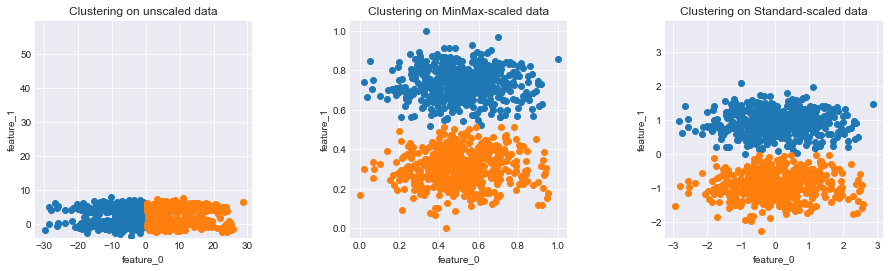

In [197]:
#4) plotting the results
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(filtered_labels_0[:,0] , filtered_labels_0[:,1])
ax1.scatter(filtered_labels_1[:,0] , filtered_labels_1[:,1])
ax1.axis('square')
ax1.set_title('Clustering on unscaled data')
ax1.set_xlabel('feature_0')
ax1.set_ylabel('feature_1')

ax2.scatter(filtered_labels_minmax_0[:,0] , filtered_labels_minmax_0[:,1])
ax2.scatter(filtered_labels_minmax_1[:,0] , filtered_labels_minmax_1[:,1])
ax2.axis('square')
ax2.set_title('Clustering on MinMax-scaled data')
ax2.set_xlabel('feature_0')
ax2.set_ylabel('feature_1')

ax3.scatter(filtered_labels_standard_0[:,0] , filtered_labels_standard_0[:,1])
ax3.scatter(filtered_labels_standard_1[:,0] , filtered_labels_standard_1[:,1])
ax3.axis('square')
ax3.set_title('Clustering on Standard-scaled data')
ax3.set_xlabel('feature_0')
ax3.set_ylabel('feature_1')

plt.show()

**Выводы:**
- Кластеризация немасштабированных данных проведена ложно по причине того, что расстояния между разномасштабными признаками рассчитывалась неверно по причине того, что большие по масштабу признаки обладали большим удельным весом в полученном Евклидовом расстоянии.
- Напротив, кластеризация равномасштабных признаков (MinMax или Standard) проведена корректно.

## Exercise  3 - Preprocessing Pipeline (2 points)

In [227]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

- Проведем эксперимент, использую указанные в задании параметры. 
    - В качестве средства масштабирования используем  StandardScaler.
    - В качестве средства выбора информативных признаков используем  RandomForestClassifier.

In [229]:
result_score = pd.DataFrame(index=['original','scaled','scaled_selected'], columns=['score'])
logit = LogisticRegression(solver='liblinear', penalty='l1')

#1) prediction based on original data.
pipe_original = make_pipeline(logit)
pipe_original.fit(wine_train, wine_labels_train)
result_score.at['original', 'score'] = pipe_original.score(wine_val, wine_labels_val)

#2) prediction based on scaled (Standard) data.
pipe_scaled = make_pipeline(StandardScaler(), logit)
pipe_scaled.fit(wine_train, wine_labels_train)
result_score.at['scaled', 'score'] = pipe_scaled.score(wine_val, wine_labels_val)

#3) prediction based on scaled (MinMax) data with feature selection.
rf = RandomForestClassifier(n_estimators=15, random_state=17)
pipe_scaled_selected = make_pipeline(StandardScaler(), SelectFromModel(estimator=rf), logit)
pipe_scaled_selected.fit(wine_train, wine_labels_train)
result_score.at['scaled_selected', 'score'] = pipe_scaled_selected.score(wine_val, wine_labels_val)

result_score.head()

,score
original,0.981481
scaled,0.981481
scaled_selected,1.0


- Повторим эксперимент, используя кросс-валидацию.

In [232]:
result_sv_score = pd.DataFrame(index=['original','scaled','scaled_selected'], columns=['score'])
logit = LogisticRegression(solver='liblinear', penalty='l1')

#1) prediction based on original data.
pipe_original = make_pipeline(logit)
result_sv_score.at['original', 'score'] = cross_val_score(pipe_original, 
                                                       wine_data, 
                                                       wine_labels, 
                                                       scoring="accuracy", 
                                                       cv=5
                                                      ).mean()

#2) prediction based on scaled (Standard) data.
pipe_scaled = make_pipeline(StandardScaler(), logit)
result_sv_score.at['scaled', 'score'] = cross_val_score(pipe_scaled,
                                                     wine_data, 
                                                     wine_labels, 
                                                     scoring="accuracy", 
                                                     cv=5
                                                    ).mean()


#3) prediction based on scaled (MinMax) data with feature selection.
rf = RandomForestClassifier(n_estimators=15, random_state=17)
pipe_scaled_selected = make_pipeline(StandardScaler(), SelectFromModel(estimator=rf), logit)
result_sv_score.at['scaled_selected', 'score'] = cross_val_score(pipe_scaled_selected,
                                                              wine_data,
                                                              wine_labels, 
                                                              scoring="accuracy", 
                                                              cv=5
                                                             ).mean()

result_sv_score.head()

,score
original,0.961111
scaled,0.983333
scaled_selected,0.983333


**Выводы:**
- Использование средств масштабирования признаков (scaling) и выбора наиболее информативных из них (feature selection) позволяет значительно повысить точность распознавания. Данный факт наиболее наглядно продемонстрирован в случае использования кросс-валидации (для повышения достоверности получаемых результатов).

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [245]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [286]:
standard_scaler = StandardScaler()
wine_data_standard = standard_scaler.fit_transform(wine_data)
mean_vec=np.mean(wine_data_standard,axis=0)
cov_matrix=(wine_data_standard-mean_vec).T.dot((wine_data_standard-mean_vec))/(wine_data_standard.shape[0]-1)
S = cov_matrix

If your code is correct, the following assert should be Ok.

In [337]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [338]:
from scipy.optimize import minimize

def objective(x):
    return -(x.T@S@x)
    

def norm_constraint(x):
    norm = np.linalg.norm(x)
    return 0 if norm == 1 else (norm-1)
    

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(13)

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [339]:
def orthogonality_constraint(x):
    return x.T@x0

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros(13)


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [340]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

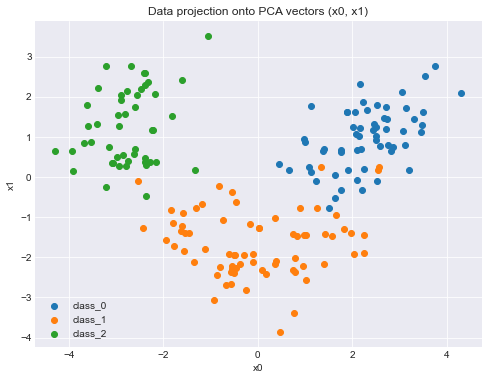

In [408]:
# Project data to x0 and x1 vectors.

# class_0
data_x0_0 = np.dot(wine_data_standard[wine_labels==0,:], x0)
data_x1_0 = np.dot(wine_data_standard[wine_labels==0,:], x1)

# class_1
data_x0_1 = np.dot(wine_data_standard[wine_labels==1,:], x0)
data_x1_1 = np.dot(wine_data_standard[wine_labels==1,:], x1)

# class_2
data_x0_2 = np.dot(wine_data_standard[wine_labels==2,:], x0)
data_x1_2 = np.dot(wine_data_standard[wine_labels==2,:], x1)

# Plot results.
plt.figure(figsize=(8,6))
plt.scatter(data_x0_0, data_x1_0)
plt.scatter(data_x0_1, data_x1_1)
plt.scatter(data_x0_2, data_x1_2)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Data projection onto PCA vectors (x0, x1)')
plt.legend(('class_0','class_1','class_2'))
plt.show()

**Выводы:**
- После преобразования признаков на базе PCA и выделения двух основных компонент (x0 и x1) стало возможным отобразить данных на 2D-графике. При этом можно заметить, что при такой конфигурации данных обозначенные в наборе классы (class_0, class_1, class_2) практически линейно разделимы.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [356]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

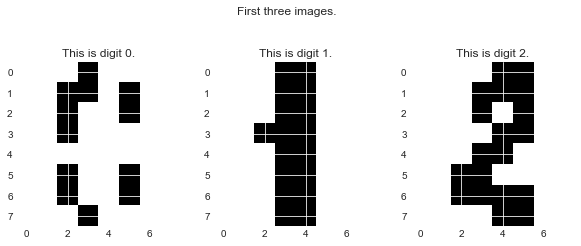

In [357]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [409]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [410]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [411]:
clf = RandomForestClassifier(max_depth=13)

clf.fit(X_train, y_train)
acc = clf.score(X_val, y_val)

print(acc)

0.9876543209876543


In [412]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [373]:
# ! pip install boruta

In [402]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x7FC197DD6540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FC197DD6540)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

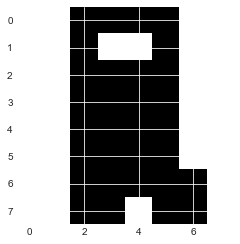

In [403]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [406]:
clf = RandomForestClassifier(max_depth=13)
clf.fit(X_train.iloc[:,feat_selector.support_], y_train)

acc = clf.score(X_val.iloc[:,feat_selector.support_], y_val)
print(acc)

0.9938271604938271


In [407]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market